# Doorrekenen opgeschaalde buien

In deze notebook worden de opgeschaalde buien doorgerekend. Hiervoor wordt de uitvoer van de voorgaande notebooks gebruikt, namelijk:
- De eigenschappen van de piekbuien
- De schalingsfactoren om op de gewenste terugkeertijden uit te komen.

Zoals eerder besproken, wordt de opschaling gedaan op basis van de piekbui van 31-10-1998. Het volume in de opgeschaalde varianten van die bui wordt ook toegekend aan de andere 4 piekbuien, waarmee deze dus eigen schaalfactoren krijgen.

In [1]:
# Importeren van modules

# Standaardmodules
import datetime
import os
import shutil
import sys
if '..' not in sys.path:
    sys.path.append('..')

# Specifieke functies voor POV Vecht
from povvecht import io, statistics, analysis, plotting, bsub
import imp
imp.reload(plotting)
import hkvsobekpy as hkv
    
# Analyse
import geopandas as gpd
from netCDF4 import Dataset
import numpy as np
import pandas as pd

# Visualiseren
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm import tnrange
% matplotlib inline

In [2]:
# Opgeven invoerparameters en paden

# parameters
p1 = 1.40
p2 = 1.55
basisjaar = 1998

# paden
hbv_model_dir = 'r:/pr/3694_10/sbk3694'
sobek_model_dir = 'r:/pr/3694_10/sbkRIV25209/Model/KNMI50/data'
datafolder = '../data'
piekbui_bestand = 'eigenschappen_piekbuien.csv'
meteo_datasets = [
    'vecht_1951-2006.nc',
    'vecht_2007-2016_EOBS.nc'
]

In [3]:
# Importeren benodigde gegevens
# piekbuien
piekbuien = pd.read_csv(os.path.join(datafolder, piekbui_bestand), index_col=0)
display(piekbuien)
# neerslag
rainfall = io.read_meteo_data([os.path.join(datafolder, ds) for ds in meteo_datasets], datatype='rainfall_rate')
display(rainfall.head())

evaporation = io.read_meteo_data([os.path.join(datafolder, ds) for ds in meteo_datasets], datatype='reference_evaporation_rate')
temperature = io.read_meteo_data([os.path.join(datafolder, ds) for ds in meteo_datasets], datatype='air_temperature')

models = pd.read_csv(os.path.join(datafolder, 'models.csv'))
shifts = (models.set_index('location').dropna()['timeshift'].astype(int) * -1).to_dict()
display(models)

,peak_date,t_start,t_end,max,sum
1998,1998-10-30 00:00:00,1998-10-22 00:00:00,1998-11-04 00:00:00,56.360651,162.878890
1960,1960-12-05 00:00:00,1960-12-01 00:00:00,1960-12-07 00:00:00,48.676073,72.460894
1968,1968-01-15 00:00:00,1968-01-09 00:00:00,1968-01-19 00:00:00,10.596797,37.130163
1986,1986-12-31 00:00:00,1986-12-24 00:00:00,1987-01-03 00:00:00,24.899296,104.934647
2001,2001-02-07 00:00:00,2001-02-01 00:00:00,2001-02-09 00:00:00,20.926608,56.083529


,SteinfurterAa_1,SteinfurterAa_2,VechteB_1,VechteB_2,VechteB_3,VechteC_2,Dinkel_1,Dinkel_3,Radewijkerbeek_2,Streukelerzijl_1,...,Radewijkerbeek_1,Ommerkanaal_2,Ommerkanaal_1,CPK_1,VechteC_1,CPK_2,CPK_3,CPK_4,VechteA_1,VechteA_2
1951-01-01,2.84,3.01,2.49,2.27,2.85,3.02,2.70,2.96,2.27,2.41,...,1.23,2.76,1.94,2.78,2.50,5.16,4.83,4.89,3.43,2.76
1951-01-02,2.25,1.75,0.65,1.03,2.59,2.37,1.12,2.19,2.65,2.82,...,2.75,2.25,2.91,1.87,2.56,1.40,1.93,2.35,1.21,1.10
1951-01-03,0.00,0.74,1.67,1.71,0.37,0.19,0.51,0.57,0.23,0.43,...,0.21,0.55,0.31,0.25,0.37,0.27,0.46,0.63,0.01,0.66
1951-01-04,1.47,1.21,1.20,1.21,1.80,1.83,2.42,2.01,1.78,1.84,...,1.12,1.79,1.48,2.76,2.04,2.57,2.09,2.26,2.36,1.78
1951-01-05,8.72,8.57,9.91,9.90,11.24,9.29,8.72,10.76,6.33,9.71,...,7.78,8.13,10.01,7.26,10.95,7.93,6.81,10.01,10.13,9.26


,location,model,timeshift,subdir
0,Regge,Regge,0.0,Regge_021
1,Kostverlorenzijl,Kost,NaN,Kost_022
2,Kloosterzijl,Kost,NaN,Kost_022
3,Vechte a,VechteA,-2.0,VechteA_023
4,Mastenbroek,Masten,NaN,Masten_024
5,Streukelerzijl,Streukel,NaN,Streukel_025
6,Vecht,Vecht,0.0,Vecht_026
7,Sallandse Wetering,Salland,NaN,Salland_027
8,Radewijke,Radewijk,-1.0,Radewijk_029
9,Afw. kanaal,Afkanaal,-1.0,Afkanaal_030


## Schaalfactoren
Bepaal schaalfactoren voor de piekbuien

In [17]:
piekbuien.loc[basisjaar, 'p1'] = p1
piekbuien.loc[basisjaar, 'p2'] = p2

for year, piek in piekbuien.iloc[1:].iterrows():
    if year in [1968, 2001]:
        piekbuien.at[year, 'p1'] = 1.70
        piekbuien.at[year, 'p2'] = 1.85
    
    else:
        piekbuien.at[year, 'p1'] = p1
        piekbuien.at[year, 'p2'] = p2
    
display(piekbuien)

,peak_date,t_start,t_end,max,sum,p1,p2
1998,1998-10-30 00:00:00,1998-10-22 00:00:00,1998-11-04 00:00:00,56.360651,162.878890,1.4,1.55
1960,1960-12-05 00:00:00,1960-12-01 00:00:00,1960-12-07 00:00:00,48.676073,72.460894,1.4,1.55
1968,1968-01-15 00:00:00,1968-01-09 00:00:00,1968-01-19 00:00:00,10.596797,37.130163,1.7,1.85
1986,1986-12-31 00:00:00,1986-12-24 00:00:00,1987-01-03 00:00:00,24.899296,104.934647,1.4,1.55
2001,2001-02-07 00:00:00,2001-02-01 00:00:00,2001-02-09 00:00:00,20.926608,56.083529,1.7,1.85


## HBV sommen

Voorbereiden invoer

In [18]:
# Lees standaard casedesc
with open(os.path.join(hbv_model_dir, 'inputfiles', 'casedesc.cmt_org'), 'r') as f:
    text = f.read()
    
# Open bsub voor hbv
hbv_bsub = open(os.path.join(hbv_model_dir, 'run_scaled_models.sh'), 'w')

for year, piek in piekbuien.iloc[[2]].iterrows():
    
    for p in ['p1', 'p2']:
        
        case_id = 'knmi_{}_{}'.format(year, '{:3d}p'.format(int(piek[p] * 100)))
        
        # Determine start time and end time for simulation
        t_start = datetime.datetime.strptime(piek['t_start'], '%Y-%m-%d %H:%M:%S') - datetime.timedelta(days=60)
        t_end = datetime.datetime.strptime(piek['t_end'], '%Y-%m-%d %H:%M:%S') + datetime.timedelta(days=7)
        
        # Neerslag
        io.write_bui(
            fname=os.path.join(hbv_model_dir, 'Fixed', case_id + '.bui'), 
            df_prc=rainfall.loc[t_start : t_end] * piek[p],
            timestepsize=60*60*24,
            start_date='1999-01-01'
        )
        
        io.write_evp(
            fname=os.path.join(hbv_model_dir, 'Fixed', case_id + '.evp'), 
            series=evaporation.loc[t_start : t_end].mean(axis=1),
            start_date='1999-01-01'
        )
        
        io.write_tmp(
            fname=os.path.join(hbv_model_dir, 'Fixed', case_id + '.tmp'), 
            series=temperature.loc[t_start : t_end].mean(axis=1),
            start_date='1999-01-01'
        )
        
        # Create casedesc
        with open(os.path.join(hbv_model_dir, 'inputfiles', 'casedesc.cmt_{}'.format(case_id)), 'w') as f:
            f.write(text.replace('KNMI50', case_id))
            
        bsub.write_hbv_bsub(hbv_bsub, nodes=None, models=models, modeldir=hbv_model_dir, case_id=case_id)

hbv_bsub.close()

Uitlezen en opslaan resultaat
    

In [22]:
for year, piek in piekbuien.iloc[[2]].iterrows():
    
    for p in ['p1', 'p2']:
        
        dfs = []
        
        case_id = 'knmi_{}_{}'.format(year, '{:3d}p'.format(int(piek[p] * 100)))
        
        hisfilename = '{}_BNDFLODT.HIS'.format(case_id)
        for model in models.itertuples():

            hispath = os.path.join(hbv_model_dir, model.model+'.lit', 'hisfiles', hisfilename)
            localpath = 'c:/{}'.format(hisfilename)
            shutil.copy2(hispath, localpath)

            rehis = hkv.read_his.LeesMetadata(hispath)
            parameters = rehis.KrijgParameters()

            df_rehis=rehis.MultiWaardenArary(
                [model.location],
                parameters[0:1],
                startMMdd=(1, 1),
                endMMdd=(12, 31),
                jaarmax_as='none',
                drop_lege_jaren=False
            )

            df_rehis.index = pd.to_datetime(df_rehis.index)
            df_rehis.columns = [model.location]

            dfs.append(df_rehis)
            
            os.remove(localpath)
        
        df = pd.concat(dfs, axis=1)
        
        # Converteer indices naar integers
        df.index = [int('{:04d}{:02d}{:02d}'.format(date.year, date.month, date.day)) for date in df.index]
        
        df.to_csv(os.path.join(datafolder, 'HBV_{}_{}.csv'.format(year, '{:3d}p'.format(int(piek[p] * 100)))))


## SOBEK sommen

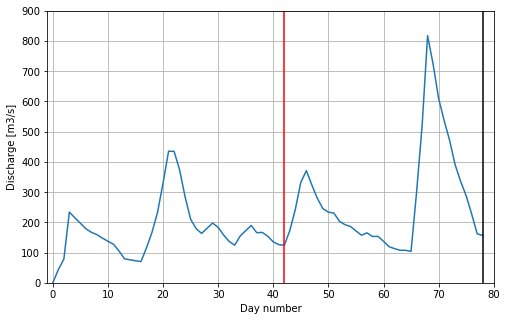

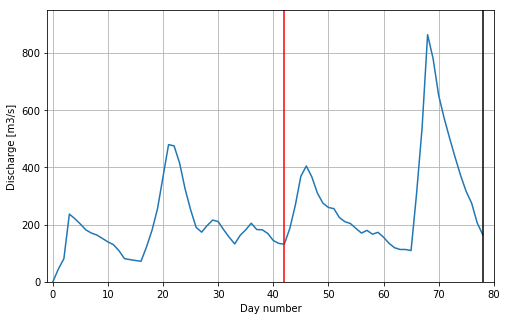

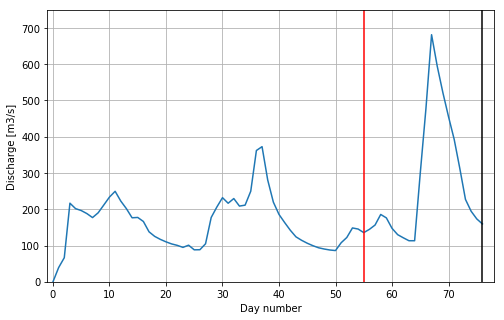

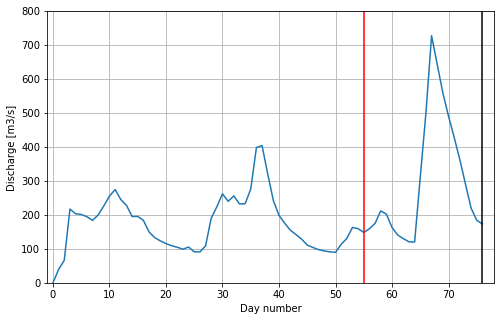

In [32]:
df_bound = pd.read_csv(os.path.join(datafolder, 'koppelingstabel.csv'))
bsub_name = 'bsub_sobek_scaled.sh'

# Read the base files
defcnd2 = open(os.path.join(sobek_model_dir, 'DEFCND.2'), 'r').readlines()
defcnd3 = open(os.path.join(sobek_model_dir, 'DEFCND.3'), 'r').readlines()

# Create directory if it does not exist
directory = os.path.join(sobek_model_dir, 'inputfiles')
if not os.path.exists(directory):
    os.makedirs(directory)

df_defcnd2 = df_bound[df_bound['Boundary file'] == 'DEFCND.2']
df_defcnd3 = df_bound[df_bound['Boundary file'] == 'DEFCND.3']

# Open bsub file and overview file
bsub_file = open(os.path.join(sobek_model_dir, bsub_name), 'w')
runids = []

for year, piek in piekbuien.iloc[[2, 4]].iterrows():
    
    for p in ['p1', 'p2']:
        
               
        case_id = 'knmi_{}_{}'.format(year, '{:3d}p'.format(int(piek[p] * 100)))

        df = pd.read_csv(os.path.join(datafolder, 'HBV_{}_{}.csv'.format(year, '{:3d}p'.format(int(piek[p] * 100)))), index_col=0)
        dalfsen = pd.DataFrame(analysis.time_shift(df, shifts).sum(axis=1), columns=['shifted'], index=df.index)

        # Select relevant wave part
        t_start, t_end, dt = analysis.select_time_part(
            dalfsen,
            threshold=150,
            midpoint=dalfsen.reset_index()['shifted'].argmax(),
            column='shifted',
            plot_result='../figuren/{}.png'.format(case_id)
        )

        # Replace the boundary conditions and write to file
        io.replace_sobek_boundary(
            base_lines=defcnd2[:],
            df_subset=df_defcnd2,
            df_bndflow=df.loc[t_start:t_end],
            filename=os.path.join(sobek_model_dir, 'inputfiles', 'DEFCND.2_' + case_id),
            trigger='XXXX'
        )    

        # Replace the boundary conditions and write to file
        io.replace_sobek_boundary(
            base_lines=defcnd3[:],
            df_subset=df_defcnd3,
            df_bndflow=df.loc[t_start:t_end],
            filename=os.path.join(sobek_model_dir, 'inputfiles', 'DEFCND.3_' + case_id),
            trigger='XXXX'
        )

        # Write defrun
        endtime = (datetime.datetime(year=2000, month=1, day=1) + datetime.timedelta(days=int(dt))).strftime('%Y/%m/%d;%H:%M:%S')
        with open(os.path.join(sobek_model_dir, 'inputfiles', 'DEFRUN.1_' + case_id), 'w') as f:
            f.write(("FLTM "
                     "bt '2000/01/01;00:00:00' "
                     "et '{}' "
                     "ct '01:00:00' cd 0 tp '12:25:00' dp 0 ba '' tt 75 tf 1 nt 1 if 0 im 1 ri 0 fltm"
                     ).format(endtime))

        runids.append(case_id)

io.write_sobek_bsub(bsub_file, "3694_10", "sbkRIV25209", "KNMI50", 0, runids)

bsub_file.close()


In [33]:
Stat_Dalfsen = {
    'T': [
        1.0, 2.0, 5.0, 10.0, 20.0,
        50.0, 100.0, 250.0, 500.1, 1250.3,
        2000.1, 3999.7, 9998.0, 20000.8, 50005.0,
        99980.0, 999800.0
    ],
    'Q': [
        180.0, 216.0, 264.0, 300.0, 335.0,
        383.0, 419.0, 459.0, 490.0, 530.0,
        551.0, 582.0, 609.0, 623.0, 637.0, 
        643.0, 662.0
    ]
}

df_Dalfsen = pd.DataFrame(data=Stat_Dalfsen)

knmi_1998_140p 603.833862305
knmi_1998_155p 657.466491699
knmi_1960_140p 512.333129883
knmi_1960_155p 550.012268066
knmi_1968_170p 519.081604004
knmi_1968_185p 550.836425781
knmi_1986_140p 505.560882568
knmi_1986_155p 543.691040039
knmi_2001_170p 425.73449707
knmi_2001_185p 452.884490967


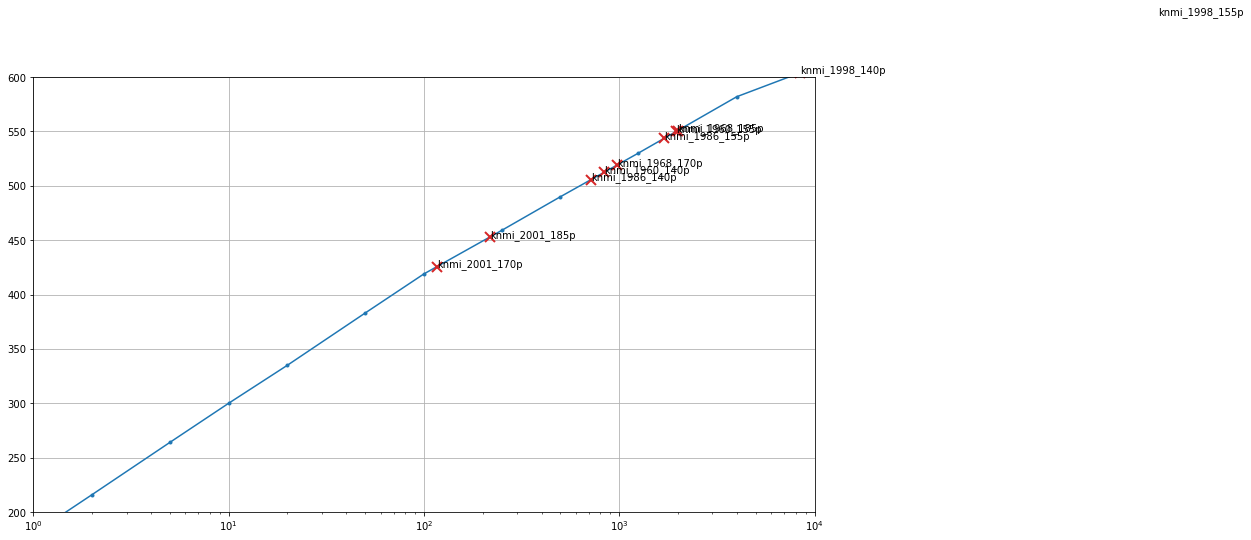

In [34]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xscale('log')
ax.set_ylim(200, 600)
ax.set_xlim(1, 10000)
ax.grid()
ax.plot(df_Dalfsen['T'], df_Dalfsen['Q'], marker='.', ls='-')

ps = np.arange(110, 151, 5).astype(int)
Ts = []
maxima = []
case_ids = []

for year, piek in piekbuien.iterrows():
    
    for p in ['p1', 'p2']:
        
        case_id = 'knmi_{}_{}'.format(year, '{:3d}p'.format(int(piek[p] * 100)))
        
        his_file = os.path.join(sobek_model_dir, '..',case_id, 'work', 'flowhis.his')
        localpath = 'c:/flowhis.his'
        shutil.copy2(his_file, localpath)
        maximum = io.get_sobek_maximum(localpath, skip_timesteps=24*2)
        os.remove(localpath)

        Tinterp = np.exp(np.interp(maximum, df_Dalfsen['Q'], np.log(df_Dalfsen['T'])))
        Ts.append(Tinterp)
        maxima.append(maximum)
        case_ids.append(case_id)
        
        ax.text(Tinterp, maximum, case_id)
        
        print(case_id, maximum)

    
        # 1.20 -> 464

ax.plot(Ts, maxima, marker='x', color='C3', markersize=10, mew=2, ls='')

# print(np.interp(np.log([500, 5000]), np.log(Ts), maxima))


In [35]:
index = pd.MultiIndex.from_tuples([(case_id.split('_')[1], case_id.split('_')[2]) for case_id in case_ids])
df = pd.DataFrame(data=np.c_[maxima, np.zeros(len(Ts)), Ts], index=index, columns=['Q_sobek', 'Q_hbv', 'T_sobek'])

for idx, row in df.iterrows():
    hbv = pd.read_csv('../data/HBV_{}_{}.csv'.format(*idx), index_col=0)
    hbvmax = analysis.time_shift(hbv, shifts).sum(axis=1).max()
    df.set_value(idx, 'Q_hbv', hbvmax)

display(df)
df.to_csv('../data/schaling_vaste_factoren.csv')

Q_sobek       Q_hbv        T_sobek
1998 140p  603.833862  843.606326    8390.392998
     155p  657.466492  926.429760  577174.894690
1960 140p  512.333130  753.543007     834.156809
     155p  550.012268  824.198852    1956.387309
1968 170p  519.081604  817.268323     973.616276
     185p  550.836426  863.144895    1992.794020
1986 140p  505.560883  669.385236     714.284218
     155p  543.691040  725.965794    1698.389672
2001 170p  425.734497  680.974943     116.680463
     185p  452.884491  726.240680     217.320085

In [27]:
case_ids

['knmi_1998_140p',
 'knmi_1998_155p',
 'knmi_1960_140p',
 'knmi_1960_155p',
 'knmi_1968_170p',
 'knmi_1968_185p',
 'knmi_1986_140p',
 'knmi_1986_155p',
 'knmi_2001_170p',
 'knmi_2001_185p']